## Task 1

### Setup and Imports

In [6]:
# %% [markdown]
# # Task 1: CNN Classification for Pneumonia Detection (CPU Optimized)
# 
# This notebook performs training and evaluation of CNN models on the PneumoniaMNIST dataset using only CPU.

# %% [code]
# Setup paths and imports
import sys
from pathlib import Path

# Add root directory to path
root_dir = Path.cwd().parent
sys.path.append(str(root_dir))

print(f"✅ Root directory: {root_dir}")

# %% [code]
# Import required libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
import json
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Import project modules
from data.data_loader import PneumoniaMNISTDataset
from models.cnn_model import create_model
from utils.metrics import calculate_metrics, print_metrics_report
from utils.visualization import plot_training_history, plot_confusion_matrix, plot_roc_curve

print("✅ All imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"CPU Cores available: {torch.get_num_threads()}")

# Force CPU usage
torch.set_num_threads(min(4, torch.get_num_threads()))
print(f"Using {torch.get_num_threads()} CPU threads")

✅ Root directory: c:\Users\HP\Desktop\Alfsaisal University\Github Submission
✅ All imports successful
PyTorch version: 2.7.1+cu118
CPU Cores available: 10
Using 4 CPU threads


### Configuration

In [9]:
# %% [markdown]
# ## Configuration
# 
# Set your training parameters below (optimized for CPU):

# %% [code]
# Configuration
class Config:
    # Model parameters
    model_name = 'custom'  # Options: 'custom', 'resnet18', 'efficientnet-b0'
    # 'custom' is fastest on CPU, 'resnet18' is medium, 'efficientnet-b0' is slower
    
    # Training parameters (CPU optimized)
    batch_size = 16  # Reduced for CPU (was 32)
    epochs = 10  # Increase to 30-50 for better results
    learning_rate = 0.001
    patience = 5  # Early stopping patience
    
    # Data parameters
    augment = True  # Use data augmentation (slightly slower but better accuracy)
    
    # System parameters (CPU only)
    device = 'cpu'  # Force CPU usage
    num_workers = 0  # Set to 0 for CPU to avoid multiprocessing issues
    pin_memory = False  # Disable pin_memory for CPU
    
    # Paths
    models_dir = Path('../task1_classification/models/saved')
    reports_dir = Path('../task1_classification/reports/task1')
    figures_dir = Path('../task1_classification/reports/task1/figures')

# Create directories
Config.models_dir.mkdir(parents=True, exist_ok=True)
Config.reports_dir.mkdir(parents=True, exist_ok=True)
Config.figures_dir.mkdir(parents=True, exist_ok=True)

# Display configuration
print("📋 Configuration (CPU Optimized):")
print(f"   Model: {Config.model_name}")
print(f"   Batch Size: {Config.batch_size} (reduced for CPU)")
print(f"   Epochs: {Config.epochs}")
print(f"   Learning Rate: {Config.learning_rate}")
print(f"   Augmentation: {Config.augment}")
print(f"   Device: {Config.device}")
print(f"   CPU Threads: {torch.get_num_threads()}")

📋 Configuration (CPU Optimized):
   Model: custom
   Batch Size: 16 (reduced for CPU)
   Epochs: 10
   Learning Rate: 0.001
   Augmentation: True
   Device: cpu
   CPU Threads: 4


### Load Dataset (CPU Optimized)

INFO:data.data_loader:Training set size: 4708
INFO:data.data_loader:Validation set size: 524
INFO:data.data_loader:Test set size: 624


📂 Loading dataset...

✅ Dataset loaded:
   Training samples: 4708
   Validation samples: 524
   Test samples: 624
   Classes: ['Normal', 'Pneumonia']
   Class weights: tensor([0.0008, 0.0003])
   Batch size: 16 (optimized for CPU)


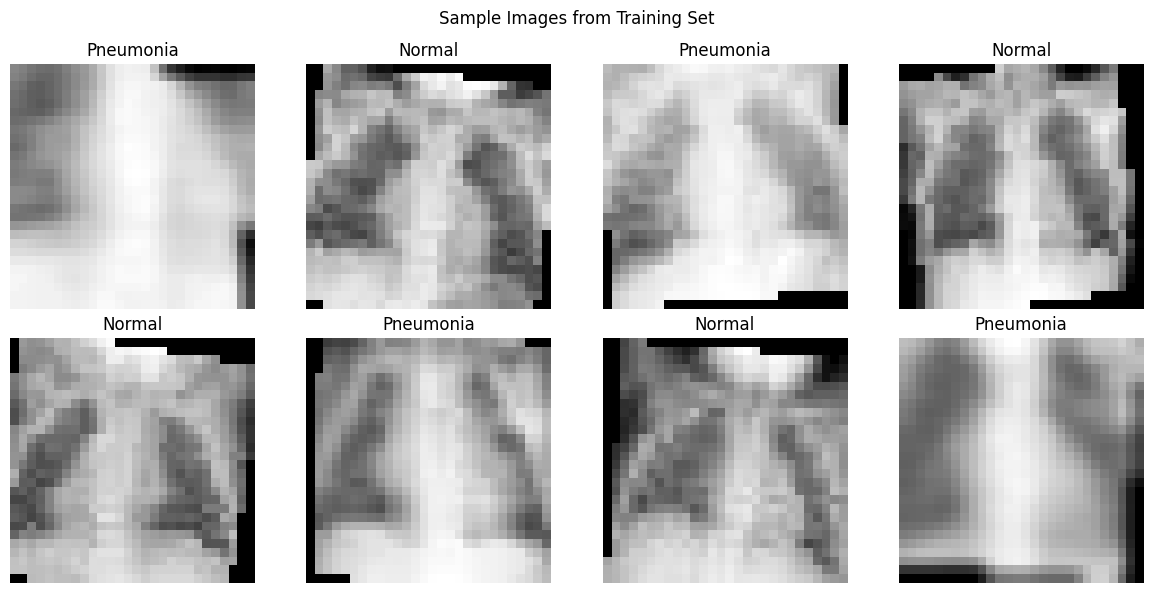

In [10]:
# %% [markdown]
# ## Load PneumoniaMNIST Dataset

# %% [code]
print("📂 Loading dataset...")

# Initialize dataset with CPU-optimized settings
dataset = PneumoniaMNISTDataset(
    batch_size=Config.batch_size,
    augment=Config.augment,
    num_workers=Config.num_workers,  # 0 for CPU
    pin_memory=Config.pin_memory     # False for CPU
)

# Get dataloaders
train_loader, val_loader, test_loader = dataset.get_dataloaders()
class_names = dataset.get_class_names()
class_weights = dataset.class_weights

print(f"\n✅ Dataset loaded:")
print(f"   Training samples: {len(train_loader.dataset)}")
print(f"   Validation samples: {len(val_loader.dataset)}")
print(f"   Test samples: {len(test_loader.dataset)}")
print(f"   Classes: {class_names}")
print(f"   Class weights: {class_weights}")
print(f"   Batch size: {Config.batch_size} (optimized for CPU)")

# %% [code]
# Visualize sample images
def show_sample_images(loader, num_images=8):
    images, labels = next(iter(loader))
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()
    
    for i in range(min(num_images, len(images))):
        img = images[i].squeeze().numpy()
        # Denormalize
        img = (img * 0.5) + 0.5
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'{class_names[labels[i]]}')
        axes[i].axis('off')
    
    # Hide empty subplots
    for i in range(min(num_images, len(images)), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('Sample Images from Training Set')
    plt.tight_layout()
    plt.show()

show_sample_images(train_loader)

### Create Model (CPU Optimized)

In [11]:
# %% [markdown]
# ## Create Model
# 
# Note: For CPU, 'custom' model is fastest. Use 'resnet18' for better accuracy but slower training.

# %% [code]
print(f"🧠 Creating {Config.model_name} model (CPU optimized)...")

# Create model (set pretrained=False for CPU efficiency)
model = create_model(
    model_name=Config.model_name,
    num_classes=len(class_names),
    pretrained=False  # Don't load pretrained weights for CPU speed
)

# Move to device (CPU)
device = torch.device(Config.device)
model = model.to(device)

# Loss function with class weights
criterion = torch.nn.CrossEntropyLoss(
    weight=class_weights.to(device) if class_weights is not None else None
)

# Optimizer
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=Config.learning_rate,
    weight_decay=1e-4
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✅ Model created:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Device: CPU")
print(f"   Expected training time: {'~5-10 min' if Config.model_name=='custom' else '~15-30 min'} for 10 epochs")

🧠 Creating custom model (CPU optimized)...

✅ Model created:
   Total parameters: 101,506
   Trainable parameters: 101,506
   Device: CPU
   Expected training time: ~5-10 min for 10 epochs


### Training Functions (CPU Optimized)

In [12]:
# %% [markdown]
# ## Training Functions

# %% [code]
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch (CPU optimized)."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        if labels.dim() > 1:
            labels = labels.squeeze()
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    """Validate the model."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation', leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            if labels.dim() > 1:
                labels = labels.squeeze()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

### Training Loop (CPU Optimized)

In [13]:
# %% [markdown]
# ## Training Loop
# 
# This will take longer on CPU. Consider reducing epochs for faster testing.

# %% [code]
print("="*60)
print("STARTING TRAINING (CPU MODE)")
print("="*60)
print("⚠️  Training on CPU will be slower than GPU")
print("   Estimated time: ~1-2 minutes per epoch")
print("="*60)

# Training history
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'learning_rates': [], 'epoch_times': []
}

best_val_acc = 0.0
patience_counter = 0
start_time = time.time()

for epoch in range(Config.epochs):
    epoch_start = time.time()
    
    print(f"\nEpoch {epoch+1}/{Config.epochs}")
    print("-"*40)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['learning_rates'].append(current_lr)
    history['epoch_times'].append(time.time() - epoch_start)
    
    # Print progress
    print(f"\nTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"Learning Rate: {current_lr:.6f}")
    print(f"Time: {history['epoch_times'][-1]:.2f}s")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        model_path = Config.models_dir / f'best_model_{Config.model_name}.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'model_name': Config.model_name
        }, model_path)
        print(f"✓ New best model saved! Val Acc: {val_acc:.2f}%")
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= Config.patience:
        print(f"\n⚠️ Early stopping triggered after {epoch+1} epochs")
        break

total_time = time.time() - start_time
print("\n" + "="*60)
print(f"Training completed in {total_time:.2f}s ({total_time/60:.2f} minutes)")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print("="*60)

STARTING TRAINING (CPU MODE)
⚠️  Training on CPU will be slower than GPU
   Estimated time: ~1-2 minutes per epoch

Epoch 1/10
----------------------------------------


Training:   0%|          | 0/295 [00:00<?, ?it/s]

Validation:   0%|          | 0/33 [00:00<?, ?it/s]


Train Loss: 0.3147, Train Acc: 87.00%
Val Loss: 0.2509, Val Acc: 87.40%
Learning Rate: 0.001000
Time: 9.19s
✓ New best model saved! Val Acc: 87.40%

Epoch 2/10
----------------------------------------


Training:   0%|          | 0/295 [00:00<?, ?it/s]

Validation:   0%|          | 0/33 [00:00<?, ?it/s]


Train Loss: 0.2249, Train Acc: 91.42%
Val Loss: 0.6483, Val Acc: 67.75%
Learning Rate: 0.001000
Time: 4.31s

Epoch 3/10
----------------------------------------


Training:   0%|          | 0/295 [00:00<?, ?it/s]

Validation:   0%|          | 0/33 [00:00<?, ?it/s]


Train Loss: 0.2077, Train Acc: 91.95%
Val Loss: 0.2295, Val Acc: 84.92%
Learning Rate: 0.001000
Time: 7.84s

Epoch 4/10
----------------------------------------


Training:   0%|          | 0/295 [00:00<?, ?it/s]

Validation:   0%|          | 0/33 [00:00<?, ?it/s]


Train Loss: 0.1883, Train Acc: 92.80%
Val Loss: 0.3789, Val Acc: 76.91%
Learning Rate: 0.001000
Time: 4.22s

Epoch 5/10
----------------------------------------


Training:   0%|          | 0/295 [00:00<?, ?it/s]

Validation:   0%|          | 0/33 [00:00<?, ?it/s]


Train Loss: 0.1766, Train Acc: 93.20%
Val Loss: 0.1205, Val Acc: 94.08%
Learning Rate: 0.001000
Time: 8.26s
✓ New best model saved! Val Acc: 94.08%

Epoch 6/10
----------------------------------------


Training:   0%|          | 0/295 [00:00<?, ?it/s]

Validation:   0%|          | 0/33 [00:00<?, ?it/s]


Train Loss: 0.1750, Train Acc: 93.39%
Val Loss: 0.4365, Val Acc: 77.10%
Learning Rate: 0.001000
Time: 4.22s

Epoch 7/10
----------------------------------------


Training:   0%|          | 0/295 [00:00<?, ?it/s]

Validation:   0%|          | 0/33 [00:00<?, ?it/s]


Train Loss: 0.1787, Train Acc: 93.39%
Val Loss: 0.2298, Val Acc: 85.88%
Learning Rate: 0.001000
Time: 4.22s

Epoch 8/10
----------------------------------------


Training:   0%|          | 0/295 [00:00<?, ?it/s]

Validation:   0%|          | 0/33 [00:00<?, ?it/s]


Train Loss: 0.1724, Train Acc: 93.73%
Val Loss: 0.1416, Val Acc: 96.18%
Learning Rate: 0.001000
Time: 8.09s
✓ New best model saved! Val Acc: 96.18%

Epoch 9/10
----------------------------------------


Training:   0%|          | 0/295 [00:00<?, ?it/s]

Validation:   0%|          | 0/33 [00:00<?, ?it/s]


Train Loss: 0.1564, Train Acc: 94.07%
Val Loss: 0.3102, Val Acc: 81.30%
Learning Rate: 0.000500
Time: 4.35s

Epoch 10/10
----------------------------------------


Training:   0%|          | 0/295 [00:00<?, ?it/s]

Validation:   0%|          | 0/33 [00:00<?, ?it/s]


Train Loss: 0.1441, Train Acc: 94.75%
Val Loss: 0.1387, Val Acc: 93.32%
Learning Rate: 0.000500
Time: 8.20s

Training completed in 62.96s (1.05 minutes)
Best validation accuracy: 96.18%


### Plot Training Curves

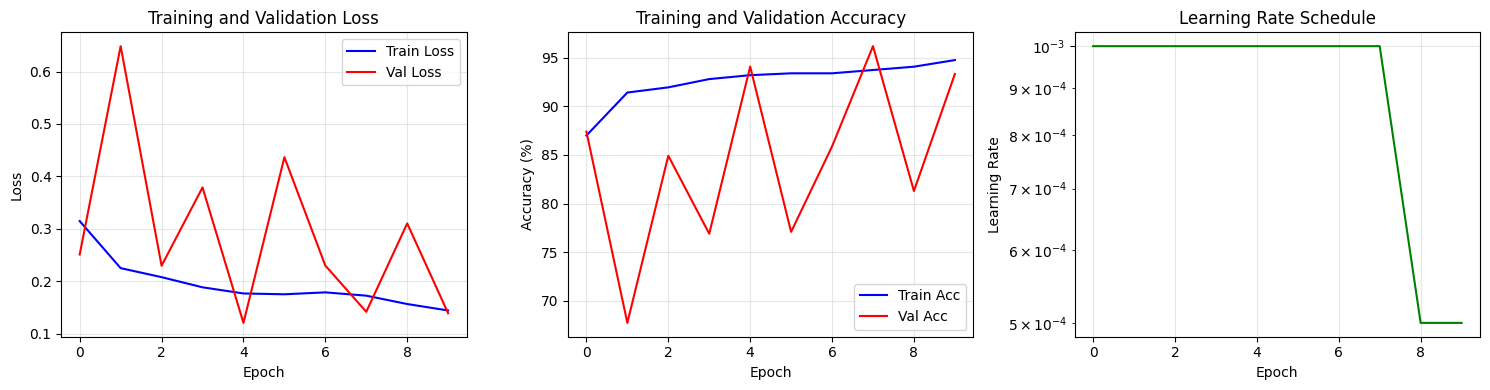

✅ Training curves saved to ..\task1_classification\reports\task1\figures\training_curves.png


In [14]:
# %% [markdown]
# ## Plot Training Curves

# %% [code]
fig = plot_training_history(history)
plt.savefig(Config.figures_dir / 'training_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Training curves saved to {Config.figures_dir / 'training_curves.png'}")

### Load Best Model for Evaluation

In [15]:
# %% [markdown]
# ## Load Best Model for Evaluation

# %% [code]
print("📊 Loading best model for evaluation...")

# Load checkpoint
model_path = Config.models_dir / f'best_model_{Config.model_name}.pth'
checkpoint = torch.load(model_path, map_location=device)

# Recreate model and load weights
model = create_model(
    model_name=Config.model_name,
    num_classes=len(class_names),
    pretrained=False
).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✅ Loaded model from epoch {checkpoint['epoch']+1} with val_acc: {checkpoint['val_acc']:.2f}%")

📊 Loading best model for evaluation...
✅ Loaded model from epoch 8 with val_acc: 96.18%


### Evaluation on Test Set

In [16]:
# %% [markdown]
# ## Evaluate on Test Set

# %% [code]
print("📊 Running evaluation on test set (CPU)...")

all_labels = []
all_preds = []
all_probs = []
all_images = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = outputs.max(1)
        
        all_labels.extend(labels.numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_images.extend(images.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

print(f"✅ Evaluated {len(all_labels)} test samples")

# Calculate metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc

accuracy = (all_preds == all_labels).mean()
cm = confusion_matrix(all_labels, all_preds)
fpr, tpr, _ = roc_curve(all_labels, all_probs[:, 1])
roc_auc = auc(fpr, tpr)

print("\n" + "="*50)
print("TEST SET RESULTS (CPU)")
print("="*50)
print(f"Accuracy:  {accuracy:.4f}")
print(f"AUC:       {roc_auc:.4f}")
print("\nConfusion Matrix:")
print(cm)

📊 Running evaluation on test set (CPU)...


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

✅ Evaluated 624 test samples

TEST SET RESULTS (CPU)
Accuracy:  0.8429
AUC:       0.9618

Confusion Matrix:
[[139  95]
 [  3 387]]


### Detailed Metrics

In [17]:
# %% [markdown]
# ## Detailed Metrics Report

# %% [code]
# Use metrics utility
print_metrics_report(all_labels, all_preds, all_probs, class_names)

# Save metrics
metrics = calculate_metrics(all_labels, all_preds, all_probs, class_names)

with open(Config.reports_dir / 'evaluation_results.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"\n✅ Metrics saved to {Config.reports_dir / 'evaluation_results.json'}")

CLASSIFICATION METRICS REPORT

CONFUSION MATRIX:
----------------------------------------
                                Predicted
                         Normal  Pneumonia
----------------------------------------
Actual Normal               139         95
Actual Pneumonia              3        387

OVERALL METRICS:
----------------------------------------
Accuracy:             0.8429
Precision:            0.8029
Recall:               0.9923
F1-Score:             0.8876
Sensitivity:          0.9923
Specificity:          0.5940
ROC-AUC:              0.9618
Cohen's Kappa:        0.6364
Youden's Index:       0.5863

PER-CLASS METRICS:
----------------------------------------

Normal:
  Precision: 0.9789
  Recall:    0.5940
  F1-Score:  0.7394
  Support:   234

Pneumonia:
  Precision: 0.8029
  Recall:    0.9923
  F1-Score:  0.8876
  Support:   390


✅ Metrics saved to ..\task1_classification\reports\task1\evaluation_results.json


### ROC Curve

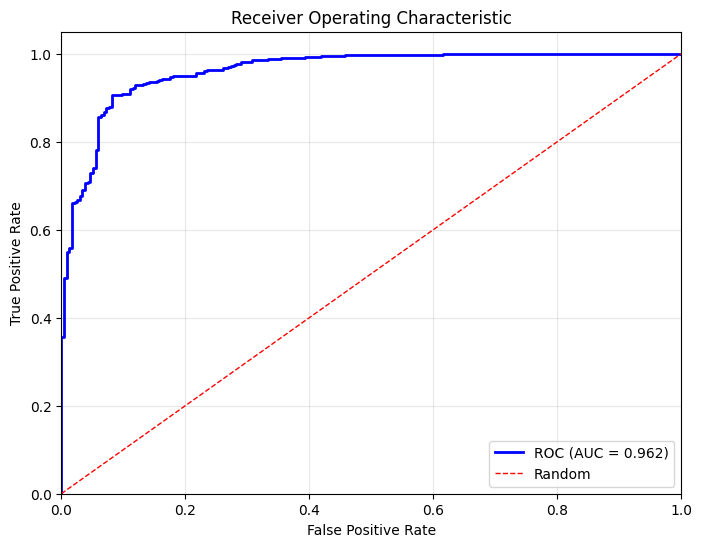

✅ ROC curve saved to ..\task1_classification\reports\task1\figures\roc_curve.png


In [18]:
# %% [markdown]
# ## ROC Curve

# %% [code]
fig = plot_roc_curve(fpr, tpr, roc_auc)
plt.savefig(Config.figures_dir / 'roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ ROC curve saved to {Config.figures_dir / 'roc_curve.png'}")

### Failure Case Analysis

📊 Total misclassified samples: 98


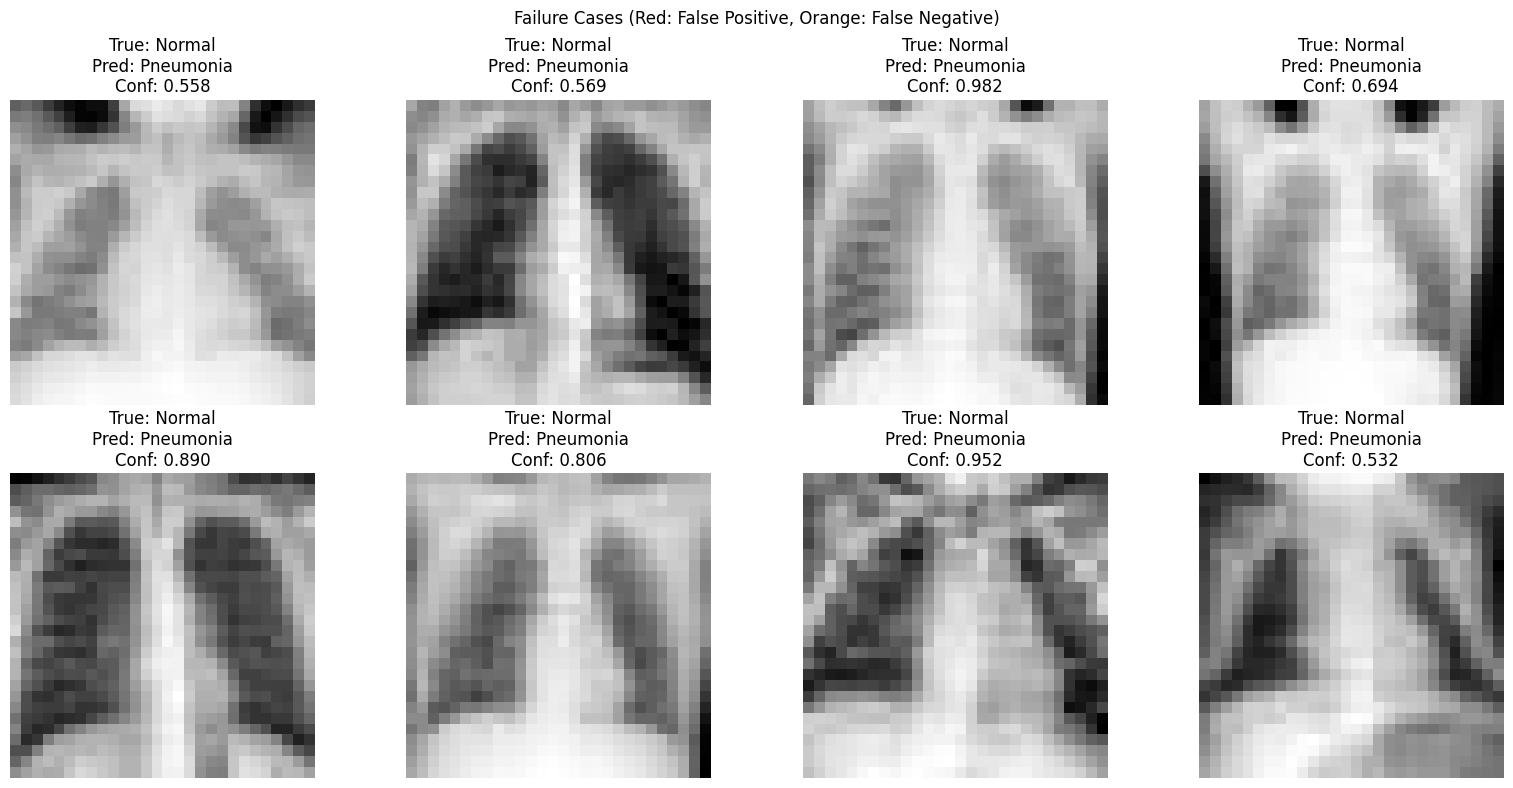

✅ Failure cases saved to ..\task1_classification\reports\task1\figures\failure_cases.png


In [19]:
# %% [markdown]
# ## Failure Case Analysis

# %% [code]
# Find misclassified samples
misclassified = np.where(all_labels != all_preds)[0]
print(f"📊 Total misclassified samples: {len(misclassified)}")

if len(misclassified) > 0:
    # Show some failure cases
    n_samples = min(8, len(misclassified))
    indices = np.random.choice(misclassified, n_samples, replace=False)
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        img = all_images[idx].squeeze()
        img = (img * 0.5) + 0.5  # Denormalize
        
        true_label = class_names[all_labels[idx]]
        pred_label = class_names[all_preds[idx]]
        confidence = all_probs[idx][all_preds[idx]]
        
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}')
        axes[i].axis('off')
        
        # Color border based on error type
        if all_labels[idx] == 0:  # False positive
            for spine in axes[i].spines.values():
                spine.set_color('red')
                spine.set_linewidth(3)
        else:  # False negative
            for spine in axes[i].spines.values():
                spine.set_color('orange')
                spine.set_linewidth(3)
    
    # Hide empty subplots
    for i in range(len(indices), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('Failure Cases (Red: False Positive, Orange: False Negative)')
    plt.tight_layout()
    plt.savefig(Config.figures_dir / 'failure_cases.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✅ Failure cases saved to {Config.figures_dir / 'failure_cases.png'}")

### Generate Markdown Report

In [20]:
# %% [markdown]
# ## Generate Markdown Report

# %% [code]
report_path = Config.reports_dir / 'task1_classification_report.md'

with open(report_path, 'w') as f:
    f.write("# Pneumonia Classification Report (CPU)\n\n")
    f.write(f"**Model:** {Config.model_name}\n")
    f.write(f"**Date:** {time.strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("## Configuration (CPU Optimized)\n\n")
    f.write(f"- Model: {Config.model_name}\n")
    f.write(f"- Batch Size: {Config.batch_size} (reduced for CPU)\n")
    f.write(f"- Epochs: {Config.epochs}\n")
    f.write(f"- Learning Rate: {Config.learning_rate}\n")
    f.write(f"- Augmentation: {Config.augment}\n")
    f.write(f"- CPU Threads: {torch.get_num_threads()}\n\n")
    
    f.write("## Test Set Results\n\n")
    f.write(f"- Accuracy: {accuracy:.4f}\n")
    f.write(f"- AUC: {roc_auc:.4f}\n")
    f.write(f"- Misclassified: {len(misclassified)}/{len(all_labels)} ({len(misclassified)/len(all_labels)*100:.2f}%)\n\n")
    
    f.write("## Confusion Matrix\n\n")
    f.write("| | Predicted Normal | Predicted Pneumonia |\n")
    f.write("|---|---|---|\n")
    f.write(f"| Actual Normal | {cm[0,0]} | {cm[0,1]} |\n")
    f.write(f"| Actual Pneumonia | {cm[1,0]} | {cm[1,1]} |\n")

print(f"✅ Report saved to {report_path}")

✅ Report saved to ..\task1_classification\reports\task1\task1_classification_report.md


### Performance Summary

In [22]:
# %% [markdown]
# ## CPU Performance Summary

# %% [code]
print("\n" + "="*60)
print("TASK 1 COMPLETED SUCCESSFULLY (CPU MODE)")
print("="*60)
print(f"\n📁 Output files saved to:")
print(f"   Models: {Config.models_dir}")
print(f"   Reports: {Config.reports_dir}")
print(f"   Figures: {Config.figures_dir}")
print("\n📊 Key Results:")
print(f"   Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"   Test Accuracy: {accuracy:.4f}")
print(f"   Test AUC: {roc_auc:.4f}")
print("\n⏱️  Training Time Statistics:")
print(f"   Total time: {total_time:.2f}s ({total_time/60:.2f} minutes)")
print(f"   Average epoch time: {np.mean(history['epoch_times']):.2f}s")
print(f"   Fastest epoch: {min(history['epoch_times']):.2f}s")
print(f"   Slowest epoch: {max(history['epoch_times']):.2f}s")
print("\n💡 CPU Optimization Tips:")
print("   - Use 'custom' model for fastest training")
print("   - Reduce batch size to 16 or 8 if memory issues")
print("   - Disable augmentation for faster training")


TASK 1 COMPLETED SUCCESSFULLY (CPU MODE)

📁 Output files saved to:
   Models: ..\task1_classification\models\saved
   Reports: ..\task1_classification\reports\task1
   Figures: ..\task1_classification\reports\task1\figures

📊 Key Results:
   Best Validation Accuracy: 96.18%
   Test Accuracy: 0.8429
   Test AUC: 0.9618

⏱️  Training Time Statistics:
   Total time: 62.96s (1.05 minutes)
   Average epoch time: 6.29s
   Fastest epoch: 4.22s
   Slowest epoch: 9.19s

💡 CPU Optimization Tips:
   - Use 'custom' model for fastest training
   - Reduce batch size to 16 or 8 if memory issues
   - Disable augmentation for faster training
